## <font color='blue'>SME0104 - Cálculo Numérico</font>

### Primeiro Trabalho em Grupo 
#### Comparação de Métodos na Solução do Laplaciano em Grafos para propagação de informação

**Luis Gustavo Nonato**

------

Considere os arquivos `manh.el` e `manh.xy` que fornecem as arestas e as coordenadas dos vértices do grafo de ruas da ilha de Manhattan, NY (arquivos disponíveis para download no Google Drive).

O grafo de ruas possui diversas componentes conexas, considerando somente a maior componente conexa, você deve realizar as seguintes tarefas:
1. Selecione alguns vértices do grafo $v_{i_1},v_{i_2},\ldots,v_{i_k},\, k<<n$ ($n$ é o número de vértices na maior componente do grafo e $k$ é um número bem menor que $n$, $k=10$ por exemplo) e atribua valores distindos $c_{i_1},c_{i_2},\ldots,c_{i_k}$ a cada um dos vértices selecionados (por exemplo valores no intervalo (0,10]);
2. Construa a matriz Laplaciana $L$ do grafo de ruas;
3. Construa a matriz de penalidades $P$, sendo $P$ é uma matriz diagonal onde a entrada $P_{jj}=\alpha$ se $j$ corresponde ao índice de algum dos vértices escolhidos no item 1 acima ($\alpha=1.0e7$ por exemplo), sendo $P_{ii}=0$ caso contrário.
4. Construa um vetor $b$ da seguinte forma:
$$
b_{j} = \left\{\begin{matrix} c_{i_s} & \text{ se } j = i_s \\ 0 & \text{ caso contrário}\end{matrix}\right.
$$
5. Compare o tempo de solução do sistema
$$
(L+P)x = Px
$$
para os métodos:
    - Decomposição LU
    - Cholesky
    - Jacobi e Gaus-Seidel
    - Gradientes Conjugados
    
6. Refaça as tarefas com representação por matriz esparsa e matrizes cheias, comparando os resultados.

In [1]:

# def componente_conexa_rec(matriz_adj, adj_copia, matriz_componente, i):
#     if(np.sum(matriz_adj[i]) == 1):
#         matriz_componente.append(matriz_adj[i])
#         np.delete(adj_copia, i, 0)

#         return

#     conectado = np.argwhere(matriz_adj[i]==1)

#     for x in conectado:
#         componente_conexa_rec(matriz_adj, adj_copia, matriz_componente, int(x))
    
# def componente_conexa(matriz_adj, matriz_copia, matriz_componente):
#     componente_conexa_rec(matriz_adj, matriz_copia, matriz_componente, 0)
#     return


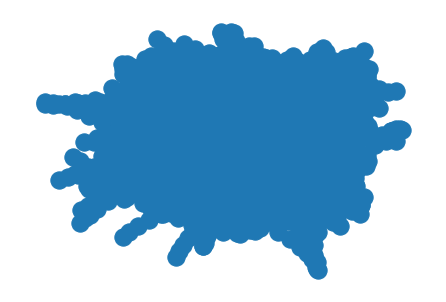

In [11]:
# Solucao
import numpy as np
import networkx as nx

el = []
xy = []
col_1 = []
col_2 = []
count = 0
aux_count = 0
  
f = open('./dados/manh.el','r')
for row in f:
    row = row.split('\t')
    row[1] = row[1].split('\n')
    aux = row[1]

    col_1.append(int(row[0]))
    col_2.append(int(aux[0]))

    el.append([int(row[0]), int(aux[0])])

f = open('./dados/manh.xy','r')
for row in f:
    row = row.split('\t')
    row[1] = row[1].split('\n')
    aux = row[1]

    xy.append([float(row[0]), float(aux[0])])
  
matriz_adjacencia = np.zeros((len(xy)+1,len(xy)+1))
matriz_grau = np.zeros((len(xy)+1,len(xy)+1))

for i in range(len(el)):
    matriz_adjacencia[el[i][0],el[i][1]] = 1
    matriz_adjacencia[el[i][1],el[i][0]] = 1

dict_frequencias = dict()
for i in col_1:
  dict_frequencias[i] = dict_frequencias.get(i, 0) + 1

for i in col_2:
  dict_frequencias[i] = dict_frequencias.get(i, 0) + 1

count = 0
for i in dict_frequencias.keys():
    count = count + 1
    matriz_grau[i][i] = dict_frequencias[i]

matriz_laplaciana = matriz_grau - matriz_adjacencia

# G = nx.Graph()
# G.add_edges_from(el)

G = nx.read_edgelist("./dados/manh.el", create_using=nx.Graph, nodetype=int)

componentes = [G.subgraph(c).copy() for c in nx.connected_components(G)]

nx.draw(componentes[0])